# <ins>APPRENTISSAGE DES IMAGES AVEC EFFICIENTNETB1 SANS PRETARAITEMENT</ins>

## <ins>CHARGEMENT DES LIBRAIRIES</ins>

In [5]:
import numpy as np
import pandas as pd
import json
import math
from glob import glob
import pathlib
import os
import projet_rakuten

import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import h5py
import keras
import pickle
import math
import time

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## <ins>CHARGEMENT DE NOS DATASETS TRAIN & TEST</ins>

In [6]:
train_df = pd.read_csv('train_df.csv', index_col=[0])
test_df = pd.read_csv('test_df.csv', index_col=[0])
train_df.prdtypecode = train_df.prdtypecode.astype('str')
# train_df.filepath = train_df.filepath.str.replace('/datas','.')
test_df.prdtypecode = test_df.prdtypecode.astype('str')
# test_df.filepath = test_df.filepath.str.replace('/datas','.')
print("train_df avec une shape de : ", train_df.shape)
display(train_df)
print("\n\n")
print("test_df avec une shape de : ", test_df.shape)
display(test_df)

train_df avec une shape de :  (57104, 3)


,prdtypecode,filepath,produit_clean
20801,10,./images/train/image_1296257106_product_412830...,music journal notebook white paper edition
34711,2705,./images/train/image_1113907088_product_278513...,paris plus belle vacances liliane après opérat...
46725,1280,./images/train/image_890867971_product_1370941...,doudou lapin patapouf kaloo peluche boule bleu...
14558,1280,./images/train/image_1282020176_product_405387...,buyiesky®peluche hiver bottes neige american g...
3039,1160,./images/train/image_900656095_product_1462627...,foil premium collecteur âmes magic mtg fleau mint
...,...,...,...
42371,1280,./images/train/image_1084440968_product_149760...,oeuf faire éclore vie marine chaque jouet plac...
11209,1301,./images/train/image_1196125321_product_318128...,lanco balle texturée naissance multicolore cao...
17922,2582,./images/train/image_1209809140_product_200372...,store bateau horizontal coolfit sable aspect c...
32031,1560,./images/train/image_1157566245_product_268685...,cintres bois naturel rangez dressing sans froi...





test_df avec une shape de :  (19035, 3)


,prdtypecode,filepath,produit_clean
81417,1320,./images/train/image_1319550229_product_421449...,papier jouet tortue tirer jouet enfants bricol...
650,2060,./images/train/image_1289199379_product_408622...,leopard cristal acrylique géométrique miroir a...
7055,1280,./images/train/image_1098949166_product_169226...,boite musique noël wish you merry christmas bo...
15371,1140,./images/train/image_1176785754_product_296131...,funko pop vinyl nfl jason witten cowboy
72558,2583,./images/train/image_1247849820_product_381357...,kit piscine acier aspect bois gré sicilia oval...
...,...,...,...
14195,1560,./images/train/image_1223180917_product_357918...,fixy table basse carrée style contemporain bla...
14133,2585,./images/train/image_1113841622_product_192875...,nettoyeur haute pression eau froide karcher pl...
37103,2585,./images/train/image_986924278_product_2933066...,raccord laiton cap vert voies raccord laiton c...
58893,1301,./images/train/image_1261417977_product_389872...,chaussettes bébé doux nondérapant sol caoutcho...


## <ins>GENERATEUR DE DONNEES</ins>

Les transformations appliquées sur notre image seront :

- une fonction de prétraitement du modèle EfficientNet : preprocess_input.
- création d'un dataset de validation de 20% du dataset train
- une rotation aléatoire sur une plage de 10 degrés.
- une translation verticale et horizontale sur une plage de 10% des dimensions de l'images.
- un agrandissement sur une plage 10% de l'image.
- un retournement aléatoire horizontal de l'image.

In [8]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                          validation_split = 0.15,
                                          rotation_range = 10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 0.1,
                                          brightness_range=[0.9, 1.1],
                                          horizontal_flip = True)


test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

## <ins>CREATION D UN DATASET TENSORFLOW A PARTIR DES CHEMINS ET DES ETIQUETTES</ins>

## <ins>ITERATEUR</ins>

Cette méthode permettra de charger les images, de générér pour chaque iteration des lots de données (batchs) transformé par le générateur d'images.

In [9]:
BATCH_SIZE = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (380,380),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    subset = 'training'
    )

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (380,380),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    subset = 'validation'
    )

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (380,380),
    batch_size= 1,
    shuffle = False,
    )

Found 48539 validated image filenames belonging to 27 classes.
Found 8565 validated image filenames belonging to 27 classes.
Found 19035 validated image filenames belonging to 27 classes.


##  <ins>CREATION DE NOTRE MODELE EFFICIENTNETB1 AVEC 7 COUCHES SUPPLEMENTAIRES</ins>

Le fait de mettre include_top = False equivaut à geler le poids des couches supérieurs  

In [11]:
# Instancie nootre modèle
base_model = tf.keras.applications.EfficientNetV2L(input_shape = (380,380,3), include_top = False, weights = 'imagenet')
# Freeze le modèle de base
base_model.trainable = False

inputs = keras.Input(shape= (380,380,3))

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True,axis=1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True, axis=1)(x)
outputs = tf.keras.layers.Dense(27, activation="softmax")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 12, 12, 1280)   │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,603,387 (456.25 MB)

 Trainable params: 1,853,467 (7.07 MB)

 Non-trainable params: 117,749,920 (449.18 MB)

## <ins>COMPILATION - FONCTION PERTE CATEGORIAL CROSSENTROPY - OPTIMIZER ADAM</ins>

nous utilisons comme fonction de perte 'loss' la focntion de perte d'entropie croisée keras.CategoricalFocalCrossentropy(). Cette dernière est recommandée lorsqu'il existe deux classes d'étiquettes ou plus et pour gérer le déséquilibre des classes sans utiliser class_weights. Nous nous attendons à ce que les étiquettes soient fournies dans une représentation one_hot.

In [12]:
model.compile(loss = keras.losses.CategoricalFocalCrossentropy(), optimizer = 'adam', metrics=['accuracy'])

## <ins>DERNIERES PREPARATION - CALLBACKS</ins>

In [13]:

save_best_models_path = "./sauvegarde_modele/efficientnetV2/modele_callback_1.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

## <ins>FIT DU MODELE EFFICIENTNETB1_V2L</ins>

Nous partageons le jeu de données dataset_train entre l'entraînement et la validation, en utilisant les proportions 80% / 20%. Les variables steps_per_epoch et validation_steps servent à calculer le nombre exact d'itérations pour chaque phase durant chaque époque. Gardez en tête que dans ce cas, les mêmes échantillons seront utilisés aussi bien pour l'entraînement que pour la validation, ce qui pourrait introduire un biais si les deux phases étaient fortement corrélées. Mais dans la majorité des cas, cela n'engendrera pas de problème significatif.

In [14]:
for layer in base_model.layers:
    layer.trainable = False

# Fit le modèle avec les callbacks spécifiés
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715438810.948714    7529 service.cc:145] XLA service 0x7fb384003dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715438810.949081    7529 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-11 14:46:52.467125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 14:46:56.514848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:171

1125/1517 ━━━━━━━━━━━━━━━━━━━━ 5:18 812ms/step - accuracy: 0.4235 - loss: 0.4384

I0000 00:00:1715439928.343959    7728 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48019', 236 bytes spill stores, 236 bytes spill loads

I0000 00:00:1715439928.655917    7722 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49042', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715439928.767734    7729 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49042', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1715439928.771108    7731 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49042', 40 bytes spill stores, 40 bytes spill loads



1517/1517 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.4366 - loss: 0.4186

I0000 00:00:1715440534.650229    7829 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8426', 260 bytes spill stores, 260 bytes spill loads



1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1788s 1s/step - accuracy: 0.4366 - loss: 0.4186 - val_accuracy: 0.5505 - val_loss: 0.2748 - learning_rate: 0.0010
Epoch 2/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1426s 936ms/step - accuracy: 0.5394 - loss: 0.2821 - val_accuracy: 0.5727 - val_loss: 0.2567 - learning_rate: 0.0010
Epoch 3/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1432s 940ms/step - accuracy: 0.5596 - loss: 0.2587 - val_accuracy: 0.5856 - val_loss: 0.2444 - learning_rate: 0.0010
Epoch 4/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1446s 949ms/step - accuracy: 0.5761 - loss: 0.2442 - val_accuracy: 0.6062 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 5/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1437s 943ms/step - accuracy: 0.5934 - loss: 0.2323 - val_accuracy: 0.6049 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 6/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1441s 946ms/step - accuracy: 0.5981 - loss: 0.2244 - val_accuracy: 0.6083 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 7/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1462s 959ms/step -

In [15]:
# Chemin pour enregistrer le modèle
model_path = "./sauvegarde_modele/efficientnetV2/efficientnetV2.keras"

# Save the cloned model
model.save(model_path)

Recupération des probabilités renvoyés par le modèke pour les 19035 images à 18:59:05


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19035/19035 ━━━━━━━━━━━━━━━━━━━━ 897s 46ms/step
Fin de la récupération à 19:14:10
Délai du modèle pour la prédiction :  0:15:05.089848
ACCURACY DU MODELE :  0.6181245074862096

F1_SCORE_WEIGHTED :  0.6096960106247588

              precision    recall  f1-score   support

          10       0.40      0.49      0.44       649
        1140       0.67      0.64      0.65       509
        1160       0.86      0.88      0.87       691
        1180       0.32      0.32      0.32       148
        1280       0.51      0.35      0.41      1105
        1281       0.37      0.33      0.35       499
        1300       0.62      0.77      0.68      1176
        1301       0.71      0.62      0.66       159
        1302       0.54      0.50      0.52       593
        1320       0.47      0.58      0.52       706
        1560       0.65      0.62      0.63      1298
        1920       0.74      0.87      0.80       988
        1940       0.73      0.68      0.70       172
        2060       0.54  

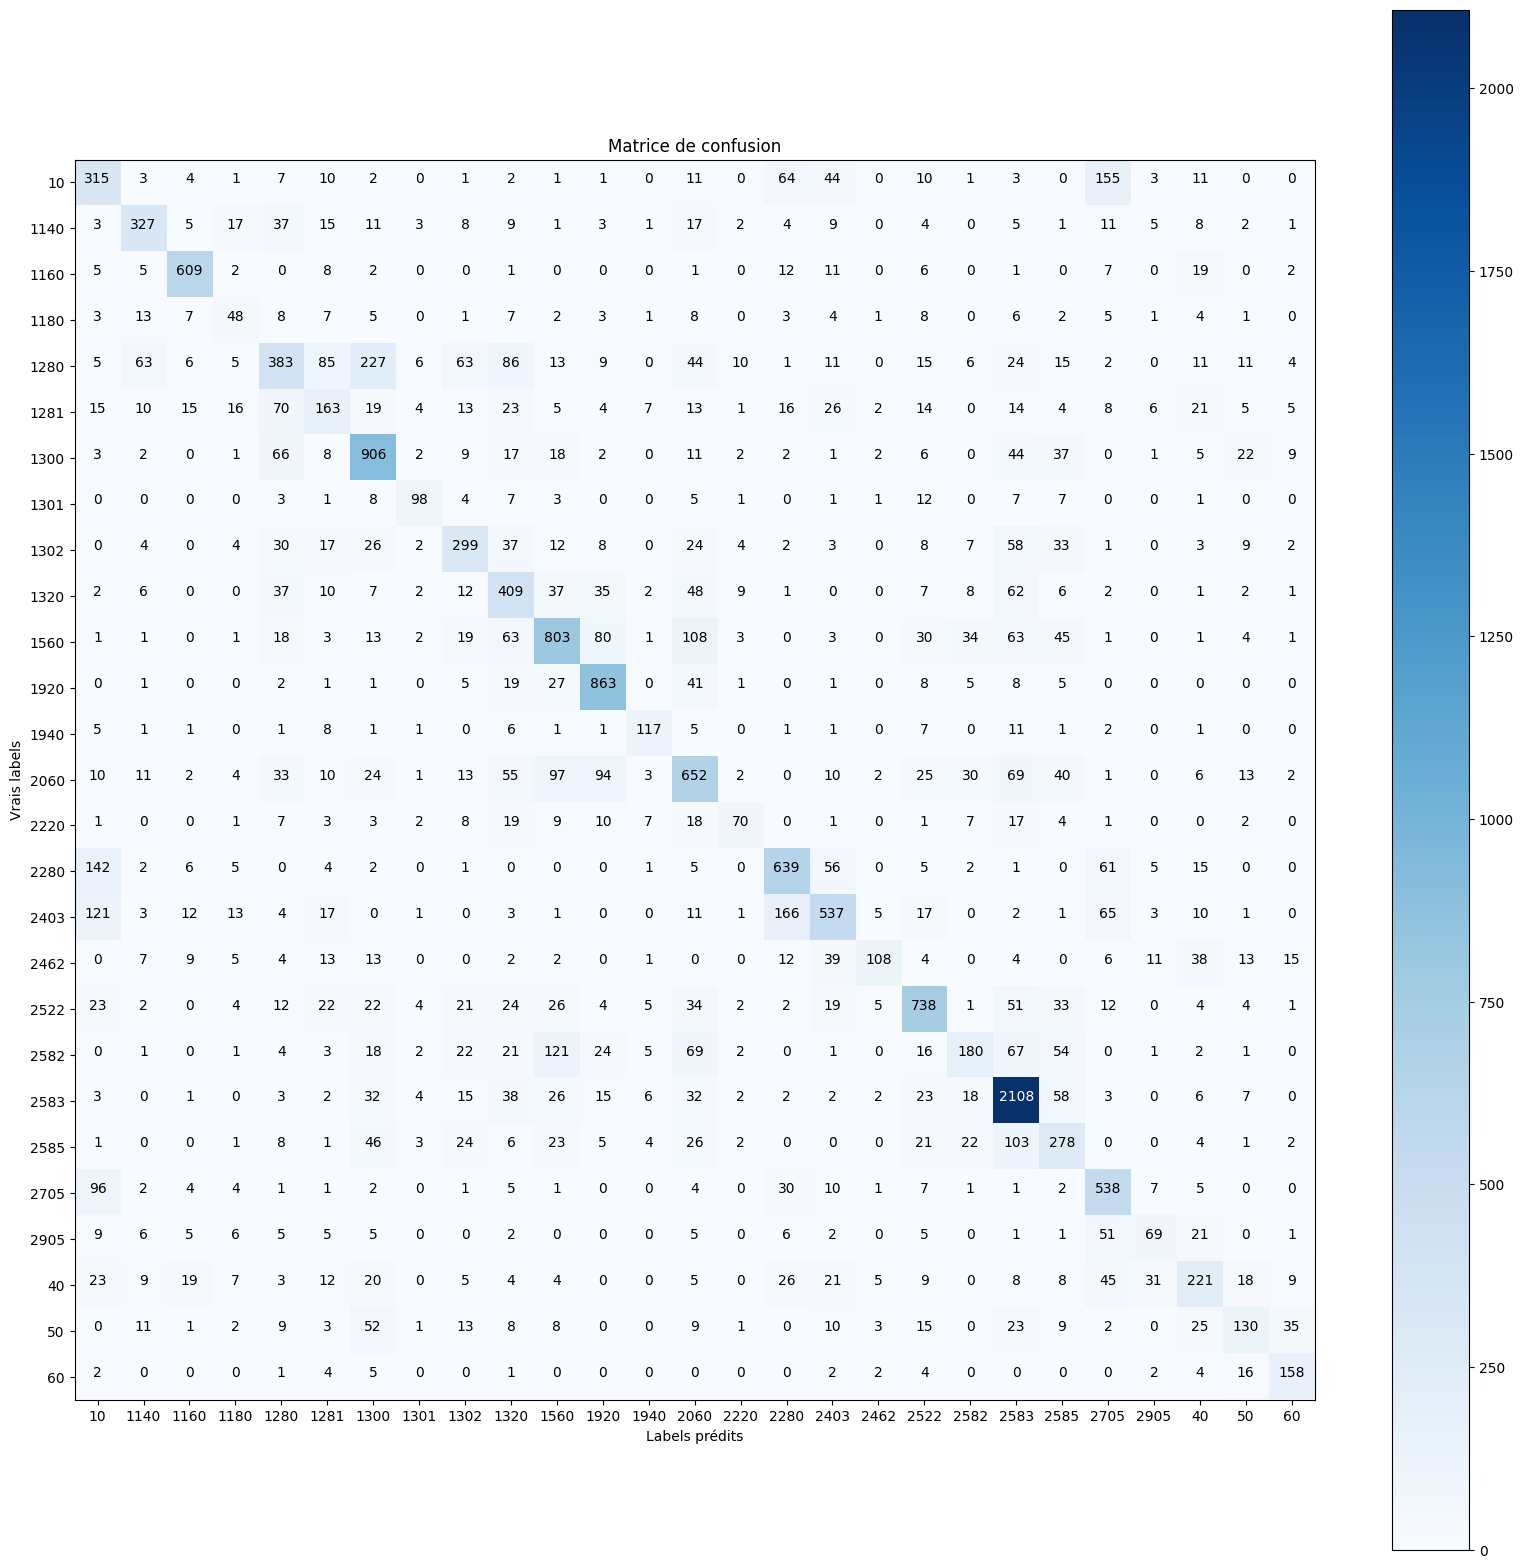

In [16]:
from projet_rakuten import predict_effnet

y_prob, y_pred, y_test, class_labels = predict_effnet(test_generator, model)

## <ins>AFFICHAGE DE LA COURBE FONCTION COUT ET PRECISION EN FONCTION DE L EPOCH</ins>

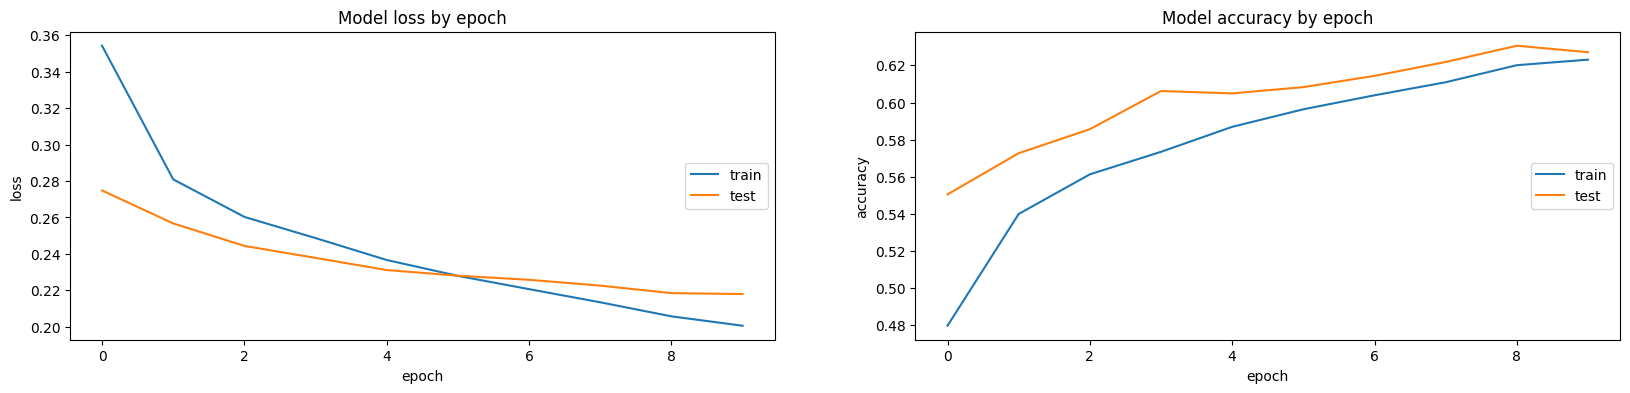

In [17]:
plt.figure(figsize = (20,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show();